<a href="https://colab.research.google.com/github/DanAIDev/camelai-firecrawl-graphagentpoc/blob/master/CAMEL_X_Firecrawl_Cookbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐫 CAMEL RAG with Firecrawl: A Comprehensive Workflow


This notebook is based on the notebook presenting the possibility of creating a knowledge graph using Firecrawl and CAMEL AI described in this article:

[Building Knowledge Graphs from Web Data using CAMEL-AI and Firecrawl](https://www.firecrawl.dev/blog/building-knowledge-graphs-from-web-data-camelai-firecrawl)

The original notebook is available through the link included in the article which I also post here for transparency reasons:
https://colab.research.google.com/drive/1Rhl5U3av0-tBZzhh45P0FuuJ7r62L4mw?authuser=1#scrollTo=dD7p_9CkyUmK

This modified notebook serves no other purpose than verification of suitability of this method for my own use case as part of a development process. The main changes are:
1. Replacement of OpenAI with Azure OpenAI
2. Change of prompts and the Agent goal

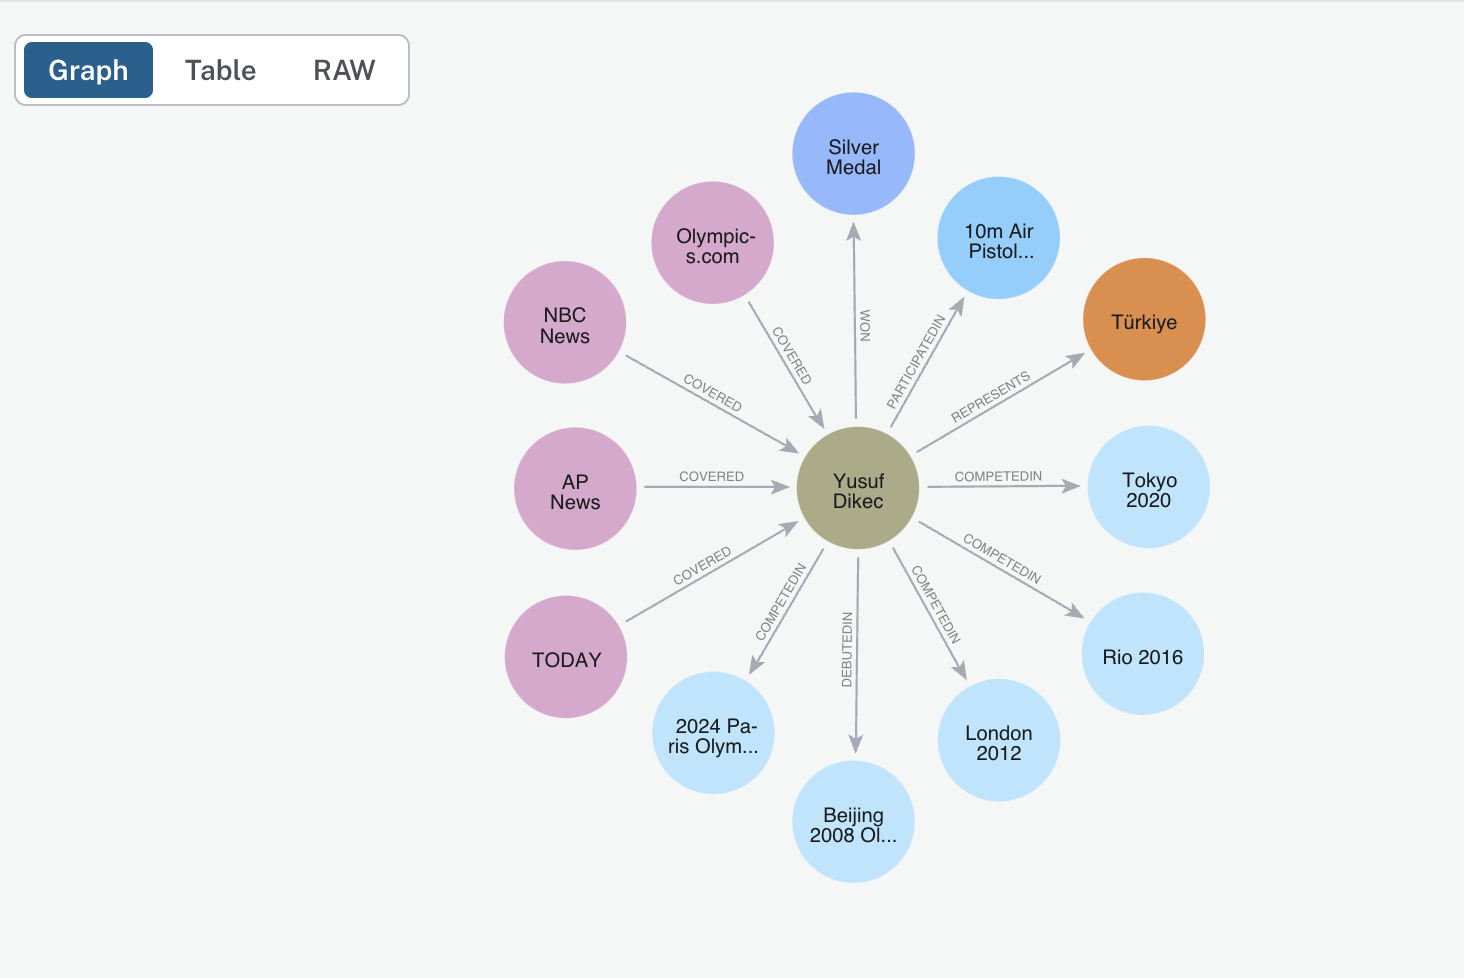

## 📦 Installation

First, install the CAMEL package with all its dependencies:

In [ ]:
pip install camel-ai[all]==0.1.6.3

## 🔑 Setting Up API Keys

You'll need to set up your API keys for both Firecrawl and OpenAI. This ensures that the tools can interact with external services securely.

Your can go to [here](https://www.firecrawl.dev/) to get **free** API Key from Firecrawl

In [ ]:
import os
from getpass import getpass

# Prompt for the Firecrawl API key securely
firecrawl_api_key = getpass('Enter your API key: ')
os.environ["FIRECRAWL_API_KEY"] = firecrawl_api_key

Enter your API key: ··········


In [ ]:
# Prompt for the Azure OpenAI API key securely
openai_api_key = getpass('Enter your Azure OpenAI API key: ')
os.environ["AZURE_OPENAI_API_KEY"] = openai_api_key

os.environ["AZURE_OPENAI_ENDPOINT"] = getpass('Enter your Azure OpenAI endpoint: ')
os.environ["AZURE_API_VERSION"] = getpass('Enter your Azure OpenAI API version: ')
os.environ["AZURE_DEPLOYMENT_NAME"] = getpass('Enter your Azure OpenAI model deployment name: ')

Enter your Azure OpenAI API key: ··········
Enter your Azure OpenAI endpoint: ··········
Enter your Azure OpenAI API version: ··········
Enter your Azure OpenAI model deployment name: ··········


## 🌐 Web Scraping with Firecrawl

Firecrawl is a powerful tool that simplifies web scraping and cleaning content from web pages. In this section, we will scrape content from a specific post on the CAMEL AI website as an example.

In [ ]:
from camel.loaders import Firecrawl

firecrawl = Firecrawl()

# Scrape and clean content from a specified URL
response = firecrawl.tidy_scrape(
    url="https://www.camel-ai.org/post/crab"
)

print(response)

**🎉 Firecrawl makes obtaining clean, LLM-friendly content from URL effortless!**

## 🛠️ Web Information Retrieval using CAMEL's RAG and Firecrawl

*In this section, we'll demonstrate how to retrieve relevant information from a list of URLs using CAMEL's RAG model. This is particularly useful for aggregating and analyzing data from multiple sources.*

### Setting Up Firecrawl with CAMEL's RAG

The following function retrieves relevant information from a list of URLs based on a given query. It combines web scraping with Firecrawl and CAMEL's AutoRetriever for a seamless information retrieval process.

In [ ]:
from camel.configs import ChatGPTConfig
from camel.models import ModelFactory
from camel.retrievers import AutoRetriever
from camel.toolkits import OpenAIFunction, SearchToolkit
from camel.types import ModelPlatformType, ModelType, StorageType

In [ ]:
def retrieve_information_from_urls(urls: list[str], query: str) -> str:
    r"""Retrieves relevant information from a list of URLs based on a given
    query.

    This function uses the `Firecrawl` tool to scrape content from the
    provided URLs and then uses the `AutoRetriever` from CAMEL to retrieve the
    most relevant information based on the query from the scraped content.

    Args:
        urls (list[str]): A list of URLs to scrape content from.
        query (str): The query string to search for relevant information.

    Returns:
        str: The most relevant information retrieved based on the query.

    Example:
        >>> urls = ["https://example.com/article1", "https://example.com/
        article2"]
        >>> query = "latest advancements in AI"
        >>> result = retrieve_information_from_urls(urls, query)
    """
    aggregated_content = ''

    # Scrape and aggregate content from each URL
    for url in urls:
        scraped_content = Firecrawl().tidy_scrape(url)
        aggregated_content += scraped_content

    # Initialize the AutoRetriever for retrieving relevant content
    auto_retriever = AutoRetriever(
        vector_storage_local_path="local_data", storage_type=StorageType.QDRANT
    )

    # Retrieve the most relevant information based on the query
    # You can adjust the top_k and similarity_threshold value based on your needs
    retrieved_info = auto_retriever.run_vector_retriever(
        query=query,
        contents=aggregated_content,
        top_k=3,
        similarity_threshold=0.5,
    )

    return retrieved_info

Let's put the retrieval function to the test by gathering some information about the 2024 Olympics.
The first run may take about 50 seconds as it needs to build a local vector database.

In [ ]:
retrieved_info = retrieve_information_from_urls(
    query="Which country won the most golden prize in 2024 Olympics?",
    urls=[
        "https://en.wikipedia.org/wiki/2024_Summer_Olympics",
        "https://olympics.com/en/paris-2024",
    ],
)

print(retrieved_info)

**🎉 Thanks to CAMEL's RAG pipeline and Firecrawl's tidy scraping capabilities, this function effectively retrieves relevant information from the specified URLs! You can now integrate this function into CAMEL's Agents to automate the retrieval process further.**

## 🧠 Knowledge Graph Construction

*A powerful feature of CAMEL is its ability to build and store knowledge graphs from text data. This allows for advanced analysis and visualization of relationships within the data.*

Set up your Neo4j instance by providing the URL, username, and password, [here](https://neo4j.com/docs/aura/auradb/getting-started/create-database/) is the guidance, check your credentials in the downloaded .txt file. Note that you may need to wait up to 60 seconds if the instance has just been set up.

In [ ]:
from camel.storages import Neo4jGraph
from camel.loaders import UnstructuredIO
from camel.agents import KnowledgeGraphAgent

def knowledge_graph_builder(text: str) -> None:
    r"""Build and store a knowledge graph from the provided text.

    This function processes the input text to create and extract nodes and relationships,
    which are then added to a Neo4j database as a knowledge graph.

    Args:
        text (str): The input text from which the knowledge graph is to be constructed.

    Returns:
        graph_elements: The generated graph element from knowlegde graph agent.
    """

    # Set Neo4j instance
    n4j = Neo4jGraph(
        url="Your_URI",
        username="Your_Username",
        password="Your_Password",
    )

    # Initialize instances
    uio = UnstructuredIO()
    kg_agent = KnowledgeGraphAgent()

    # Create an element from the provided text
    element_example = uio.create_element_from_text(text, element_id="001")

    # Extract nodes and relationships using the Knowledge Graph Agent
    graph_elements = kg_agent.run(element_example, parse_graph_elements=True)

    # Add the extracted graph elements to the Neo4j database
    n4j.add_graph_elements(graph_elements=[graph_elements])

    return graph_elements


## 🤖🤖  Multi-Agent Role-Playing with CAMEL

*This section sets up a role-playing session where AI agents interact to accomplish a task using various tools. We will guide the assistant agent to perform a comprehensive study of the Turkish shooter in the 2024 Paris Olympics.*

In [ ]:
from typing import List

from colorama import Fore

from camel.agents.chat_agent import FunctionCallingRecord
from camel.societies import RolePlaying
from camel.utils import print_text_animated

Defining the Task Prompt

In [13]:
task_prompt = """"For a given search query, create a brand-agnostic knowledge graph by:

1. Scraping relevant web articles
2. Analyzing their SEO structure to extract:
   - Entity relationships
   - Semantic keyword clusters
   - Topic hierarchies
   - E-A-T signals
   - Schema patterns

The knowledge graph should map how topics and entities interconnect while excluding source brands, company names, and direct competitor references. This structure will serve as a foundation for creating new SEO-optimized content under our brand."
"""

We will configure the assistant agent with tools for mathematical calculations, web information retrieval, and knowledge graph building.

In [14]:
retrieval_tool = OpenAIFunction(retrieve_information_from_urls)
search_tool = OpenAIFunction(SearchToolkit().search_duckduckgo)
knowledge_graph_tool = OpenAIFunction(knowledge_graph_builder)

tool_list = [
    retrieval_tool,
    search_tool,
    knowledge_graph_tool,
]

assistant_model_config = ChatGPTConfig(
    tools=tool_list,
    temperature=0.0,
)

Setting Up the Role-Playing Session

In [15]:
# Initialize the role-playing session

from camel.models import AzureOpenAIModel

ModelFactory.register_model_platform(
    ModelPlatformType.AZURE,
    AzureOpenAIModel,
    default_config={
        "api_version": os.environ["OPENAI_API_VERSION"],
        "azure_deployment": os.environ["AZURE_DEPLOYMENT_NAME"]
    }
)

role_play_session = RolePlaying(
    assistant_role_name="CAMEL Assistant",
    user_role_name="CAMEL User",
    assistant_agent_kwargs=dict(
        model=ModelFactory.create(
            model_platform=ModelPlatformType.AZURE,
            model_type=ModelType.GPT_4O,
            model_config_dict=assistant_model_config.as_dict(),
        ),
        tools=tool_list,
    ),
    user_agent_kwargs=dict(),
    task_prompt=task_prompt,
    with_task_specify=False,
)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

Print the system message and task prompt

In [ ]:
# Print system and task messages
print(
    Fore.GREEN
    + f"AI Assistant sys message:\n{role_play_session.assistant_sys_msg}\n"
)
print(Fore.BLUE + f"AI User sys message:\n{role_play_session.user_sys_msg}\n")

print(Fore.YELLOW + f"Original task prompt:\n{task_prompt}\n")
print(
    Fore.CYAN
    + "Specified task prompt:"
    + f"\n{role_play_session.specified_task_prompt}\n"
)
print(Fore.RED + f"Final task prompt:\n{role_play_session.task_prompt}\n")

AI Assistant sys message:
BaseMessage(role_name='CAMEL Assistant', role_type=<RoleType.ASSISTANT: 'assistant'>, meta_dict={'task': '"For a given search query, create a brand-agnostic knowledge graph by:\n\n1. Scraping relevant web articles\n2. Analyzing their SEO structure to extract:\n   - Entity relationships\n   - Semantic keyword clusters\n   - Topic hierarchies\n   - E-A-T signals\n   - Schema patterns\n\nThe knowledge graph should map how topics and entities interconnect while excluding source brands, company names, and direct competitor references. This structure will serve as a foundation for creating new SEO-optimized content under our brand."\n\n---\nAnswer from Perplexity: pplx.ai/share', 'assistant_role': 'CAMEL Assistant', 'user_role': 'CAMEL User'}, content='===== RULES OF ASSISTANT =====\nNever forget you are a CAMEL Assistant and I am a CAMEL User. Never flip roles! Never instruct me!\nWe share a common interest in collaborating to successfully complete a task.\nYou mus

Set the termination rule and start the interaction between agents

**NOTE**: This session will take approximately 5 minutes and will consume around $0.02 in tokens by using GPT4o.

In [ ]:
n = 0
input_msg = role_play_session.init_chat()
while n < 10: # Limit the chat to 10 turns
    n += 1
    assistant_response, user_response = role_play_session.step(input_msg)

    if assistant_response.terminated:
        print(
            Fore.GREEN
            + (
                "AI Assistant terminated. Reason: "
                f"{assistant_response.info['termination_reasons']}."
            )
        )
        break
    if user_response.terminated:
        print(
            Fore.GREEN
            + (
                "AI User terminated. "
                f"Reason: {user_response.info['termination_reasons']}."
            )
        )
        break
    # Print output from the user
    print_text_animated(
        Fore.BLUE + f"AI User:\n\n{user_response.msg.content}\n",
        0.01
    )

    # Print output from the assistant, including any function
    # execution information
    print_text_animated(Fore.GREEN + "AI Assistant:", 0.01)
    tool_calls: List[FunctionCallingRecord] = [
        FunctionCallingRecord(**call.as_dict())
        for call in assistant_response.info['tool_calls']
    ]
    for func_record in tool_calls:
        print_text_animated(f"{func_record}", 0.01)
    print_text_animated(f"{assistant_response.msg.content}\n", 0.01)

    if "CAMEL_TASK_DONE" in user_response.msg.content:
        break

    input_msg = assistant_response.msg

AuthenticationError: Error code: 401 - {'error': {'message': 'Incorrect API key provided: 9d42e9d7********************8870. You can find your API key at https://platform.openai.com/account/api-keys.', 'type': 'invalid_request_error', 'param': None, 'code': 'invalid_api_key'}}

## 🌟 Highlights

This notebook has guided you through setting up and running a CAMEL RAG workflow with Firecrawl for a complex, multi-agent role-playing task. You can adapt and expand this example for various other scenarios requiring advanced web information retrieval and AI collaboration.

Key tools utilized in this notebook include:

*   **CAMEL**: A powerful multi-agent framework that enables Retrieval-Augmented Generation and multi-agent role-playing scenarios, allowing for sophisticated AI-driven tasks.
*   **Firecrawl**: A robust web scraping tool that simplifies extracting and cleaning content from various web pages.
*   **Qdrant**: An efficient vector storage system used with CAMEL’s AutoRetriever to store and retrieve relevant information based on vector similarities.
*   **Neo4j**: A leading graph database management system used for constructing and storing knowledge graphs, enabling complex relationships between entities to be mapped and queried efficiently.
*   **DuckDuckGo Search**: Utilized within the SearchToolkit to gather relevant URLs and information from the web, serving as the primary search engine for retrieving initial content.
*   **OpenAI**: Utilized for its state-of-the-art language models, which enable tool-calling capabilities to execute external functions, while its powerful embeddings are employed for semantic search and content retrieval.

This comprehensive setup allows you to adapt and expand the example for various scenarios requiring advanced web information retrieval, AI collaboration, and multi-source data aggregation.

**CAMEL also support advanced GraphRAG, for more information please check [here](https://colab.research.google.com/drive/1meBf9w8KzZvQdQU2I1bCyOg9ehoGDK1u?authuser=1)**